### Разметка данных

Нужно вручную разметить собранные данные — имена фотографий должны иметь следующий вид: number_label.format, где number — номер изображения, label — метка («yes», если стул пролезет через дверной проём; «no», если стул не пролезет через дверной проём), format — формат (например, «jpg»).

### Обнаружение стула и дверного проёма на фотографии

#### Первоначальный план

Используя знания о цветах стула и дверного проёма, эмпирически выделить стул и дверной проём (всю их площадь, а не только границы) — посмотреть на их цвета и цвета фона на фотографии (на каждый канал (R, G, B) по отдельности и на все в совокупности), придумать как лучше всего их отделить друг от друга (если и так достаточно хорошо отделяются, то просто пройтись по всем пикселям и в зависимости от того, к какому цвету они ближе — установить его принадлежность к соответствующему предмету, если же нет — использовать фильтры для преобразования цветов, чтобы их стало проще отделять).

Будем следовать сайту https://realpython.com/python-opencv-color-spaces/, где продемонстрировано, что лучше отделять по цвету объект от фона в HSV-пространстве, а не в привычном RGB-пространстве.

Попробуем вручную отделить стул от фона при одном положении стула и при двух вариантах освещения (как мне кажется, наиболее пригодных для этого).

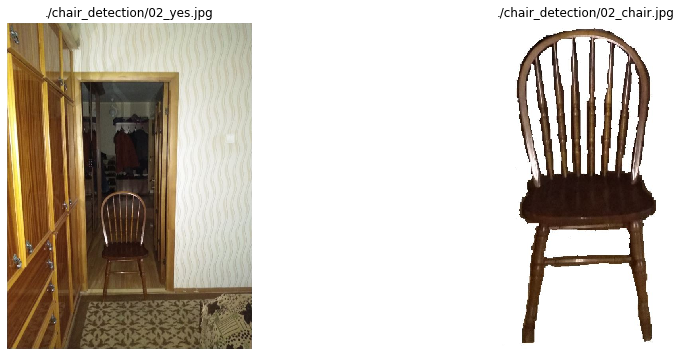

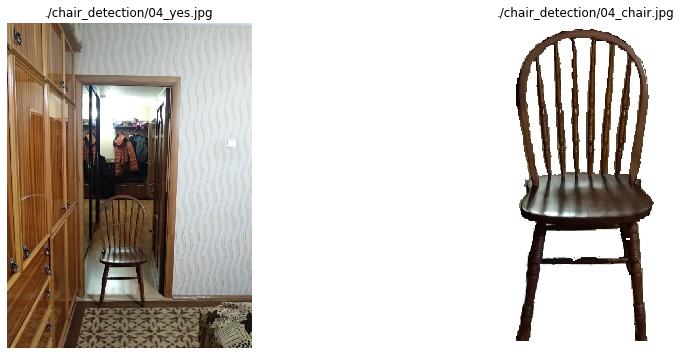

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt

image_names = ['./chair_detection/02_yes.jpg', './chair_detection/04_yes.jpg']
chair_names = ['./chair_detection/02_chair.jpg', './chair_detection/04_chair.jpg']

for image_name, chair_name in zip(image_names, chair_names):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    chair = cv2.imread(chair_name)
    chair = cv2.cvtColor(chair, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].imshow(image)
    ax[1].imshow(chair)
    
    for j in range(2): ax[j].set_axis_off()
    
    for k, title in enumerate([image_name, chair_name]): ax[k].set_title(title)
    
    plt.show()

Посмотрим теперь на фотографии и контуры стульев в HSV-пространстве.

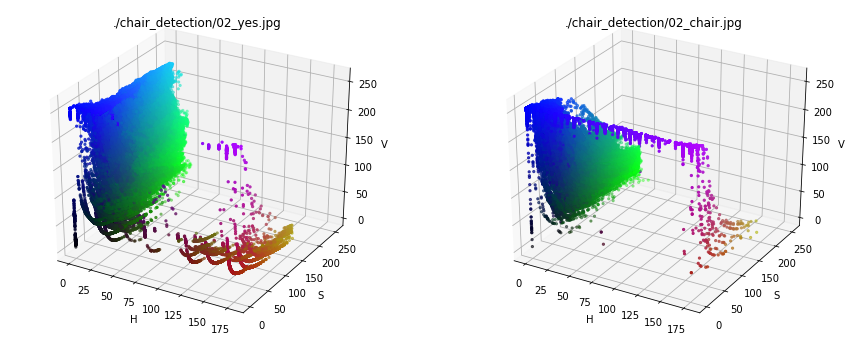

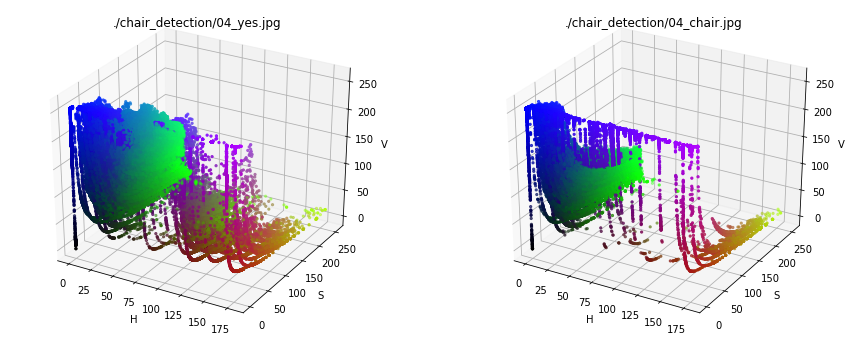

In [2]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

for image_name, chair_name in zip(image_names, chair_names):
    image = cv2.imread(image_name)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_image, s_image, v_image = cv2.split(hsv_image)
    
    chair = cv2.imread(chair_name)
    hsv_chair = cv2.cvtColor(chair, cv2.COLOR_BGR2HSV)
    h_chair, s_chair, v_chair = cv2.split(hsv_chair)
    
    pixel_colors_image = hsv_image.reshape((np.shape(hsv_image)[0]*np.shape(hsv_image)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors_image)
    pixel_colors_image = norm(pixel_colors_image).tolist()

    pixel_colors_chair = hsv_chair.reshape((np.shape(hsv_chair)[0]*np.shape(hsv_chair)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors_chair)
    pixel_colors_chair = norm(pixel_colors_chair).tolist()
    
    fig = plt.figure(figsize=(15, 6))
    
    axis_image = fig.add_subplot(1, 2, 1, projection="3d")
    axis_chair = fig.add_subplot(1, 2, 2, projection="3d")
    
    ax = [axis_image, axis_chair]
    
    ax[0].scatter(h_image.flatten(), s_image.flatten(), v_image.flatten(), facecolors=pixel_colors_image, marker=".")
    ax[1].scatter(h_chair.flatten(), s_chair.flatten(), v_chair.flatten(), facecolors=pixel_colors_chair, marker=".")
    
    for j in range(2):
        ax[j].set_xlabel("H")
        ax[j].set_ylabel("S")
        ax[j].set_zlabel("V")
    
    for k, title in enumerate([image_name, chair_name]): ax[k].set_title(title)
    
    plt.show()

Видно, что стулья не так явно отличаются от всего изображения, но всё равно попробуем сделать цветовую маску стула и посмотрим, что выделится с такой маской на изображении и на стуле. Для обоих пар кажется разумным взять цветовую маску стула как (0, 25) * (50, 255) * (0, 200).

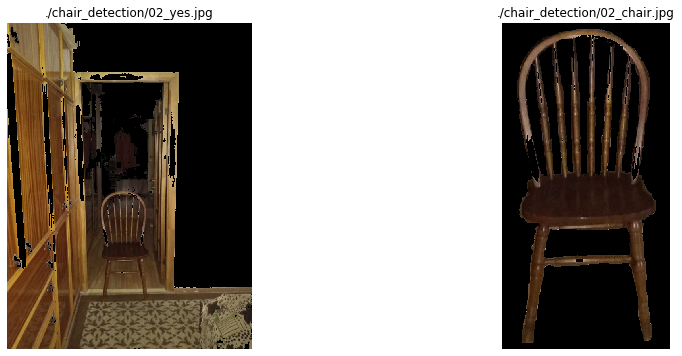

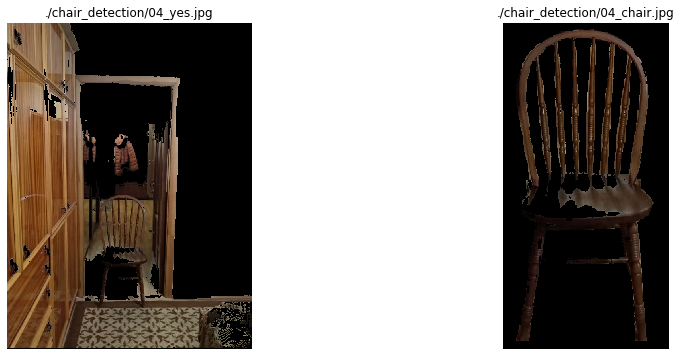

In [3]:
min_range = (0, 50, 0)
max_range = (25, 255, 200)

for image_name, chair_name in zip(image_names, chair_names):
    image = cv2.imread(image_name)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_image = cv2.inRange(hsv_image, min_range, max_range)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_image = cv2.bitwise_and(image, image, mask=mask_image)
    
    chair = cv2.imread(chair_name)
    hsv_chair = cv2.cvtColor(chair, cv2.COLOR_BGR2HSV)
    mask_chair = cv2.inRange(hsv_chair, min_range, max_range)
    chair = cv2.cvtColor(chair, cv2.COLOR_BGR2RGB)
    result_chair = cv2.bitwise_and(chair, chair, mask=mask_chair)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].imshow(result_image)
    ax[1].imshow(result_chair)
    
    for j in range(2): ax[j].set_axis_off()
    
    for k, title in enumerate([image_name, chair_name]): ax[k].set_title(title)
    
    plt.show()

Как видно, стул почти не отделился от фона - ламината, шкафа, ковра.

#### Результаты

В датасете из 50 фотографий имеется 10 разных положений стула при 5 разных освещениях. Датасет оказался сложным из-за окружения (фона) — стул не так сильно, как хотелось бы, выделяется от шкафа слева, ламината на полу и ещё существенно мешают тень и отражение света на ламинате.

Определение вердикта критически зависит от точности обнаружения (используется ширина объекта), поэтому неудовлетворительная точность обнаружения влечёт совершенно неудовлетворительные результаты. И не удалось отделить как минимум стул от отражения и тени на ламинате.

Поэтому, по-моему мнению, при таком датасете мне ничего не оставалось, как просто придумать хоть какой-то детерминированный алгоритм, который на данном датасете (то есть используя некоторые предположения и знания о датасете) даст точность >= 50% (т.е. который будет не хуже случайного алгоритма в среднем, который будет выдавать просто случайный ответ).

#### Алгоритм

Для каждой группы освещения по-своему бинаризуем фотографию (свой порог и своё условие, чтобы внутренность прохода была чёрной). Используем морфологическое закрытие, чтобы убрать некоторый шум (чёрные точки на белом фоне). И вычисляем площадь самой большой компоненты связности (белой). Оказалось, что по этому критерию — в среднем положительные ответы занимают срединное положение в своей группе по площади (т.е. из 10 ранжированных площадей в каждой группе положительные ответы находятся преимущественно с 3 по 7 (нумерация с 1) — здесь используется знание о том, что в датасете количества положительных и отрицательных ответов совпадают (берём положительные и отрицательные вердикты в равных долях)).

В целом, использовать площадь самой большой компоненты связности придумалось интуитивно — так как если стул выходит за пределы проёма, то площадь компоненты меняется. А так как съёмка велась почти из одной и той же точки, в одно и то же время при одном и том же освещении в каждой группе, то окружение (фон) вносит один и тот же вклад на каждую фотографию.

In [4]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing

def get_largest_component_area(mask):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    
    return areas[largest_comp_id]

dir = './data/'
num_lights = 5
num_pos_chairs = 10

names = os.listdir(dir)
areas = [[] * num_pos_chairs for i in range(num_lights)]

bin_signs = [">=", ">=", ">=", ">=", "<="]
bin_thresholds = [0.1, 0.2, 0.3, 0.3, 0.35]

for i in range(len(names)):
    photo = cv2.imread(dir + names[i])
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    photo_gray = rgb2gray(photo)
    
    light_opt = i % num_lights
    if (bin_signs[light_opt] == ">="):
        bin_res = photo_gray >= bin_thresholds[light_opt]
    else:
        bin_res = photo_gray <= bin_thresholds[light_opt]
    
    bin_res = binary_closing(bin_res, selem=np.ones((10, 10)))
    
    areas[light_opt].append((get_largest_component_area(bin_res), i))

### Определение вердикта

#### Первоначальный план

Поскольку на всех собранных данных дверной проём сфотографирован вертикально, и стул гораздо ниже дверного проёма, т.е. в любом своём положении высота стула меньше высоты дверного проёма, то критерием пролезания стула в дверь служит: если ширина стула не больше ширины дверного проёма, то стул пролезет в дверной проём; если ширина стула больше ширины дверного проёма, то стул не пролезет в дверной проём, где под шириной понимается максимальная горизонтальная ширина предмета, т.е. минимальная ширина прямоугольника среди множества всех прямоугольников, описывающих данный предмет.

Имея выделенные площади предметов ширину посчитать совсем не сложно — нужно пройтись построчно и найти ширину для каждой строки (расстояние между самым левым пикселем предмета и самым правым пикселем предмета в данной строке) и взять максимальную по всем строкам.

После этого вычислить вердикт по критерию тривиально.

#### Алгоритм

Соответственно внутри каждой группы ранжируем площади, с 3 по 7 (нумерация с 1) назначаем положительный вердикт, остальным — отрицательный.


In [5]:
for i in range(num_lights):
    areas[i].sort()

dict = {}
# нумерация с 0
for i in range(num_lights):
    for j in range(2):
        dict[names[areas[i][j][1]]] = 0
    
    for j in range(2, 7):
        dict[names[areas[i][j][1]]] = 1
    
    for j in range(7, num_pos_chairs):
        dict[names[areas[i][j][1]]] = 0

### Вычисление точности решения задачи

Необходимо как-то оценить точность решения задачи — разницу между ответами и вердиктами. Для этого будет использоваться точность (в процентах) — отношение верных вердиктов (вердикт совпадает с ответом) к общему числу фотографий.

In [6]:
accuracy = 0
for name in names:
    accuracy += int('yes' in name) == dict[name]

print('Точность(accuracy) = {:}%'.format(accuracy * 100 // len(names)))

Точность(accuracy) = 64%


### Репрезентативные примеры работы алгоритма

Приведу результаты работы алгоритма на группе, где достигается наибольшая точность в 80%.

Площадь =  10638387


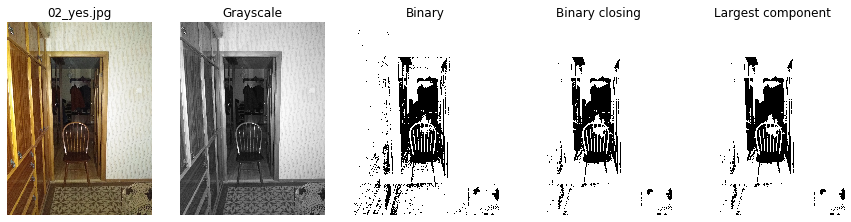

Площадь =  10344341


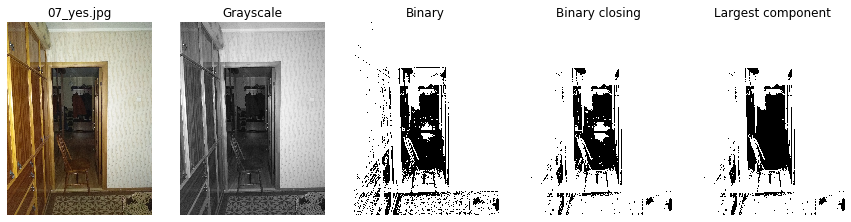

Площадь =  10654168


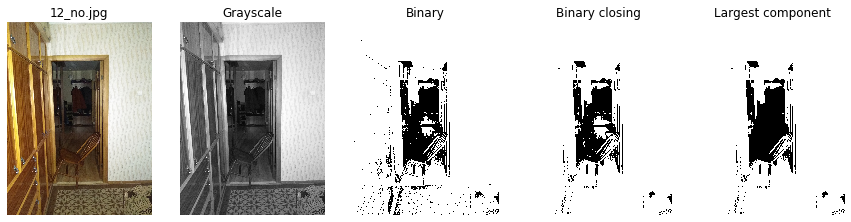

Площадь =  10473164


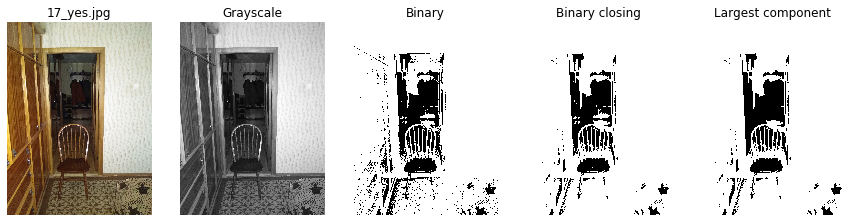

Площадь =  10678258


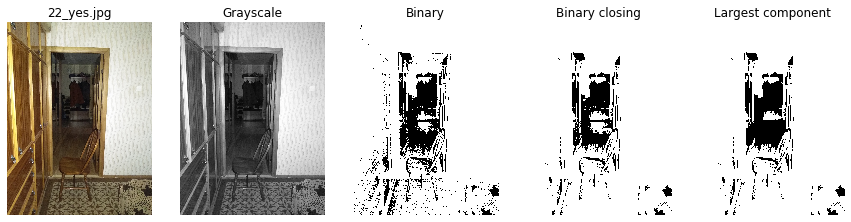

Площадь =  10651733


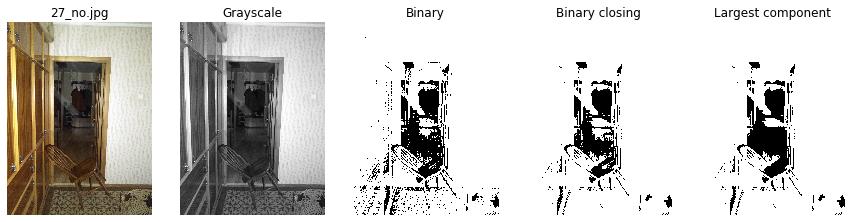

Площадь =  10734204


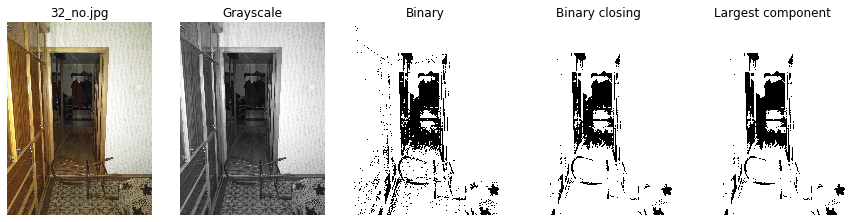

Площадь =  10295801


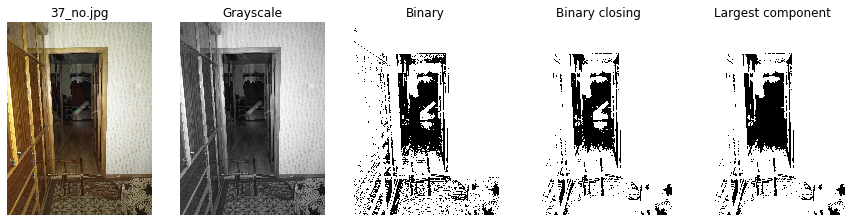

Площадь =  10132586


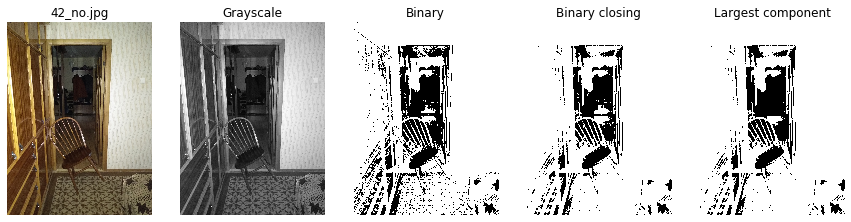

Площадь =  10367062


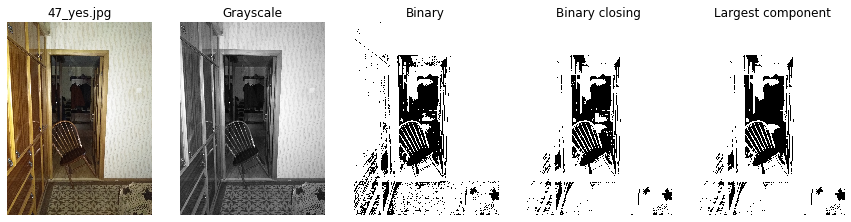

In [7]:
def get_largest_component(mask):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
    
    area = areas[largest_comp_id]
    print('Площадь = ', area)
    
    return area, labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

dir = './data/'
num_lights = 5

names = os.listdir(dir)
areas = []

for i in range(1, len(names), num_lights):
    photo = cv2.imread(dir + names[i])
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
    photo_gray = rgb2gray(photo)
    
    bin_res = photo_gray >= 0.2
    
    bin_res_c = binary_closing(bin_res, selem=np.ones((10, 10)))
    
    area, largest_component = get_largest_component(bin_res_c)
    
    fig, ax = plt.subplots(1, 5, figsize=(15, 6))
    
    ax[0].imshow(photo)
    ax[1].imshow(photo_gray, cmap='gray')
    ax[2].imshow(bin_res, cmap='gray')
    ax[3].imshow(bin_res_c, cmap='gray')
    ax[4].imshow(largest_component, cmap='gray')
    
    for j in range(5): ax[j].set_axis_off()
    
    for k, title in enumerate([names[i], 'Grayscale', 'Binary', 'Binary closing', 'Largest component']): ax[k].set_title(title)
    
    plt.show()
    
    areas.append((area, i // 5 + 1))

Хочу, отметить, что морфологическое закрытие успешно работает - шумов (чёрных точек) становится гораздо меньше

А так же в целом - внутренность проёма в целом выглядит почти одинаково на всех фотографиях (а именно это самая большая компонента чёрного, которая вносит существенный вклад в площадь самой большой белой компоненты)

Правильные ответы:

0: 3, 6, 7, 8, 9

1: 1, 2, 4, 5, 10

Посмотрим на упорядоченные площади

In [8]:
areas.sort()
print(areas)

[(10132586, 9), (10295801, 8), (10344341, 2), (10367062, 10), (10473164, 4), (10638387, 1), (10651733, 6), (10654168, 3), (10678258, 5), (10734204, 7)]


Соответственно вердикт 1 назначается с 3 по 7 месту, а именно: 2, 10, 4, 1, 6

А вердикт 0 всем остальным: 9, 8, 3, 5, 7

Неправильно определились 5 и 6 фотографии, точность для этих фотографий равна 80%.